# **What are we doing?**

We are building a basic version of a low-rank matrix factorization recommendation system and we will use it on a dataset obtained from https://grouplens.org/datasets/movielens/. It has 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. 

The other technique to build a recommendation system is an item-based collaborative filtering approach. Collaborative filtering methods that compute distance relationships between items or users are generally thought of as "neighborhood" methods, since they are centered on the idea of "nearness". 

These methods are not well-suited for larger datasets. There is another conceptual issue with them as well, i.e., the ratings matrices may be overfit and noisy representations of user tastes and preferences.When we use distance based "neighborhood" approaches on raw data, we match to sparse low-level details that we assume represent the user's preference vector instead of the vector itself. It's a subtle difference, but it's important.

If I've listened to ten Breaking Benjamin songs and you've listened to ten different Breaking Benjamin songs, the raw user action matrix wouldn't have any overlap. We'd have nothing in common, even though it seems pretty likely we share at least some underlying preferencs. We need a method that can derive the tastes and preference vectors from the raw data.

Low-Rank Matrix Factorization is one of those methods.

# **Basics of Matrix Factorization for Recommendation systems**

#### All of the theoretical explanation has been taken from: http://nicolas-hug.com/blog/matrix_facto_1

#### I could have written it myself, but I loved the explanation in the link and I would love it if people read it completely to understand how Matrix Factorization for recommendation systems actally works

The problem we need to assess is that of rating prediction. The data we would have on our hands is a **rating history**.

It would look something like this:


![jpg](Matrix_Factorization/images/Rmatrix.JPG?raw=True)

Our **R matrix** is a 99% sparse matrix withthe columns as the items or movies in our case and the rows as individual users.

We will factorize the matrix R. The matrix factorization is linked to SVD(Singular Value Decomposition). It's a beautiful result of Linear Algebra. When people say Math sucks, show them what SVD can do.

But, before we move onto SVD, we should review PCA(Principle Components Analysis). It's only slightly less awesome than SVD, but it's still pretty cool.

# **A little bit of PCA**

We’ll play around with the Olivetti dataset. It’s a set of greyscale images of faces from 40 people, making up a total of 400 images.

In [1]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
faces = fetch_olivetti_faces()
print(faces.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



**Here are the first 10 people:**

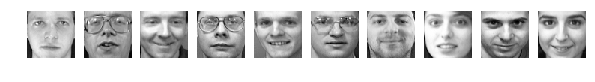

In [3]:
# Here are the first ten guys of the dataset
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot2grid((1, 10), (0, i))
    
    ax.imshow(faces.data[i * 10].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

**Each image size is 64 x 64 pixels. We will flatten each of these images (we thus get 400 vectors, each with 64 x 64 = 4096 elements). We can represent our dataset in a 400 x 4096 matrix:**

![jpg](Matrix_Factorization/images/Flattened.JPG?raw=True)

**PCA, which stands for Principal Component Analysis, is an algorithm that will reveal 400 of these guys:**

In [4]:
# Let's compute the PCA
pca = PCA()
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

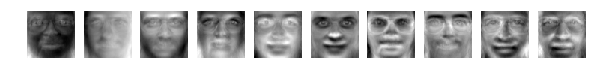

In [5]:
# Now, the creepy guys are in the components_ attribute.
# Here are the first ten ones:

fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot2grid((1, 10), (0, i))
    
    ax.imshow(pca.components_[i].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

**This is pretty creepy, right?**

We call these guys the principal components (hence the name of the technique), and when they represent faces such as here we call them the eigenfaces. Some really cool stuff can be done with eigenfaces such as face recognition, or optimizing your tinder matches! The reason why they’re called eigenfaces is because they are in fact the eigenvectors of the covariance matrix of X

We obtain here 400 principal components because the original matrix X has 400 rows (or more precisely, because the rank of X is 400). As you may have guessed, each of the principal component is in fact a vector that has the same dimension as the original faces, i.e. it has 64 x 64 = 4096 pixels.

In [6]:
# Reconstruction process

from skimage.io import imsave

face = faces.data[0]  # we will reconstruct the first face

# During the reconstruction process we are actually computing, at the kth frame,
# a rank k approximation of the face. To get a rank k approximation of a face,
# we need to first transform it into the 'latent space', and then
# transform it back to the original space

# Step 1: transform the face into the latent space.
# It's now a vector with 400 components. The kth component gives the importance
# of the kth  creepy guy
trans = pca.transform(face.reshape(1, -1))  # Reshape for scikit learn

# Step 2: reconstruction. To build the kth frame, we use all the creepy guys
# up until the kth one.
# Warning: this will save 400 png images.
for k in range(400):
    rank_k_approx = trans[:, :k].dot(pca.components_[:k]) + pca.mean_
    imsave('{:>03}'.format(str(k)) + '.jpg', rank_k_approx.reshape(64, 64))

E:\Software\Anaconda2\envs\py36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


As far as we’re concerned, we will call these guys the **creepy guys**. 

Now, one amazing thing about them is that they can build back all of the original faces. Take a look at this (these are animated gifs, about 10s long):

Each of the 400 original faces (i.e. each of the 400 original rows of the matrix) can be expressed as a (linear) combination of the creepy guys. That is, we can express the first original face (i.e. its pixel values) as a little bit of the first creepy guy, plus a little bit of the second creepy guy, plus a little bit of third, etc. until the last creepy guy. The same goes for all of the other original faces: they can all be expressed as a little bit of each creepy guy.

**Face 1 = α1⋅Creepy guy #1 + α2⋅Creepy guy #2 . . . + α400⋅Creepy guy #400**

The gifs you saw above are the very translation of these math equations: the first frame of a gif is the contribution of the first creepy guy, the second frame is the contribution of the first two creepy guys, etc. until the last creepy guy.

### Latent Factors

We’ve actually been kind of harsh towards the creepy guys. They’re not creepy, they’re typical. The goal of PCA is to reveal typical vectors: each of the creepy/typical guy represents one specific aspect underlying the data. In an ideal world, the first typical guy would represent (e.g.) a typical elder person, the second typical guy would represent a typical glasses wearer, and some other typical guys would represent concepts such as smiley, sad looking, big nose, stuff like that. And with these concepts, we could define a face as more or less elder, more or less glassy, more or less smiling, etc. In practice, the concepts that PCA reveals are really not that clear: there is no clear semantic that we could associate with any of the creepy/typical guys that we obtained here. But the important fact remains: each of the typical guys captures a specific aspect of the data. We call these aspects the latent factors (latent, because they were there all the time, we just needed PCA to reveal them). Using barbaric terms, we say that each principal component (the creepy/typical guys) captures a specific latent factor.

Now, this is all good and fun, but we’re interested in matrix factorization for recommendation purposes, right? So where is our matrix factorization, and what does it have to do with recommendation? PCA is actually a plug-and-play method: it works for any matrix. If your matrix contains images, it will reveal some typical images that can build back all of your initial images, such as here. If your matrix contains potatoes, PCA will reveal some typical potatoes that can build back all of your original potatoes. If your matrix contains ratings, well… Here we come.

# PCA on a (dense) rating matrix

Until stated otherwise, we will consider for now that our rating matrix R is completely dense, i.e. there are no missing entries. All the ratings are known. This is of course not the case in real recommendation problems, but bare with me.

### PCA on the users

Here is our rating matrix, where rows are users and columns are movies:

![jpg](Matrix_Factorization/images/UserPCA.JPG?raw=True)

Instead of having faces in the rows represented by pixel values, we now have users represented by their ratings. Just like PCA gave us some typical guys before, it will now give us some typical users, or rather some typical raters.

we would obtain a typical action movie fan, a typical romance movie fan, a typical comedy fan, etc. In practice, the semantic behind the typical users is not clearly defined, but for the sake of simplicity we will assume that they are (it doesn’t change anything, this is just for intuition/explanation purposes).

Each of our initial users (Alice, Bob…) can be expressed as a combination of the typical users. For instance, Alice could be defined as a little bit of an action fan, a little bit of a comedy fan, a lot of a romance fan, etc. As for Bob, he could be more keen on action movies:

**Alice = 10% Action fan + 10% Comedy fan + 50% Romance fan + ...**

**Bob = 50% Action fan + 30% Comedy fan + 10% Romance fan + ...**

And the same goes for all of the users, you get the idea. (In practice the coefficients are not necessarily percentages, but it’s convenient for us to think of it this way).

### PCA on the movies

What would happen if we transposed our rating matrix? Instead of having users in the rows, we would now have movies, defined as their ratings:

![jpg](Matrix_Factorization/images/MoviesPCA.JPG?raw=True)

In this case, PCA will not reveal typical faces nor typical users, but of course typical movies. And here again, we will associate a semantic meaning behind each of the typical movies, and these typical movies can build back all of our original movies:

And the same goes for all the other movies.

So what can SVD do for us? SVD is PCA on R and R(Transpose), in one shot.

SVD will give you the two matrices U and M, at the same time. You get the typical users and the typical movies in one shot. SVD gives you U and M by factorizing R into three matrices. Here is the matrix factorization:

**R=MΣU(Transpose)**

To be very clear: SVD is an algorithm that takes the matrix R as an input, and it gives you M, Σ and U, such that:

R is equal to the product **MΣU(Transpose).**

The columns of M can build back all of the columns of R (we already know this).

The columns of U can build back all of the rows of R (we already know this).

The columns of M are orthogonal, as well as the columns of U. I haven’t mentioned this before, so here it is: the principal components are always orthogonal. This is actually an extremely important feature of PCA (and SVD), but for our recommendation we actually don’t care (we’ll come to that).

Σ is a diagonal matrix (we’ll also come to that).

We can basically sum up all of the above points by this statements: the columns of M are an orthogonal basis that spans the column space of R, and the columns of U are an orthonormal basis that spans the row space of R. If this kind of phrases works for you, great. Personally, I prefer to talk about creepy guys and typical potatoes

### The model behind SVD 

When we compute and use the SVD of the rating matrix R, we are actually modeling the ratings in a very specific, and meaningful way. We will describe this modeling here.

For the sake of simplicity, we will forget about the matrix Σ: it is a diagonal matrix, so it simply acts as a scaler on M or U(Transpose). Hence, we will pretend that we have merged into one of the two matrices. Our matrix factorization simply becomes:

R=MU(Transpose)

Now, with this factorization, let’s consider the rating of user u for item i, that we will denote rui:

![jpg](Matrix_Factorization/images/productmatrices.JPG?raw=True)

Because of the way a matrix product is defined, the value of rui is the result of a dot product between two vectors: a vector pu which is a row of M and which is specific to the user u, and a vector qi which is a column of UT and which is specific to the item i:

rui=pu⋅qi,

where '⋅' stands for the usual dot product. Now, remember how we can describe our users and our items?

**Alice = 10% Action fan + 10% Comedy fan + 50% Romance fan + ...**

**Bob = 50% Action fan + 30% Comedy fan + 10% Romance fan + ...**

**Titanic = 20% Action + 0% Comedy + 70% Romance + ...**

**Toy Story = 30% Action + 60% Comedy + 0% Romance + ...**

Well, the values of the vectors pu and qi exactly correspond to the coefficients that we have assigned to each latent factor:

**pAlice=(10%,  10%,  50%, ...)**

**pBob=(50%,  30%,  10%, ...)**

**qTitanic=(20%,  0%,  70%, ...)**

**qToy Story=(30%,  60%,  0%, ...)**

The vector pu represents the affinity of user u for each of the latent factors. Similarly, the vector qi represents the affinity of the item i for the latent factors. Alice is represented as (10%,10%,50%,...), meaning that she’s only slightly sensitive to action and comedy movies, but she seems to like romance. As for Bob, he seems to prefer action movies above anything else. We can also see that Titanic is mostly a romance movie and that it’s not funny at all.

So, when we are using the SVD of R, we are modeling the rating of user u for item i as follows:

![jpg](Matrix_Factorization/images/equation.JPG?raw=True)

n other words, if u has a taste for factors that are endorsed by i, then the rating rui will be high. Conversely, if i is not the kind of items that u likes (i.e. the coefficient don’t match well), the rating rui will be low. In our case, the rating of Alice for Titanic will be high, while that of Bob will be much lower because he’s not so keen on romance movies. His rating for Toy Story will, however, be higher than that of Alice.

We now have enough knowledge to apply SVD to a recommendation task.

# **Setting up the ratings data**

In [7]:
import pandas as pd
import numpy as np

In [8]:
movies_df=pd.read_csv("E:/Git/Project markdowns/Matrix Factorization/ml-20m/movies.csv")

In [9]:
movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [10]:
ratings_df=pd.read_csv("E:/Git/Project markdowns/Matrix Factorization/ml-20m/ratings.csv")

In [11]:
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826


In [12]:
#Defining a list of numbers from 0 to 7999
mylist=range(0, 8001)

In [13]:
#Getting the data for the first 8000 users
train_df=ratings_df[ratings_df["userId"].isin(mylist)]

In [14]:
train_df

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826


In [15]:
#Time to define the R matrix that we discussed about earlier
R_df = train_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

In [16]:
R_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,129822,129857,130052,130073,130219,130462,130490,130496,130642,130768
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**The last thing we need to do is de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array.**

**With my ratings matrix properly formatted and normalized, I would be ready to do the singular value decomposition.**

In [17]:
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
R_demeaned

array([[-0.04559694,  3.45440306, -0.04559694, ..., -0.04559694,
        -0.04559694, -0.04559694],
       [-0.01698573, -0.01698573,  3.98301427, ..., -0.01698573,
        -0.01698573, -0.01698573],
       [ 3.94632788, -0.05367212, -0.05367212, ..., -0.05367212,
        -0.05367212, -0.05367212],
       ..., 
       [ 2.91806474, -0.08193526, -0.08193526, ..., -0.08193526,
        -0.08193526, -0.08193526],
       [-0.01141664, -0.01141664, -0.01141664, ..., -0.01141664,
        -0.01141664, -0.01141664],
       [-0.01127741, -0.01127741, -0.01127741, ..., -0.01127741,
        -0.01127741, -0.01127741]])

**Scipy and Numpy both have functions to do the singular value decomposition. We would be using the Scipy function svds because it let's us choose how many latent factors we want to use to approximate the original ratings matrix.**

In [18]:
from scipy.sparse.linalg import svds
M, sigma, Ut = svds(R_demeaned, k = 50)

**The function returns exactly those matrices detailed earlier in this post, except that the $\Sigma$ returned is just the values instead of a diagonal matrix. So, we will convert those numbers into a diagonal matrix.**

In [19]:
sigma = np.diag(sigma)

# **Time for Predicting**

**We would be adding the user means to the data to get the original means back**

In [20]:
allpredictedratings = np.dot(np.dot(M, sigma), Ut) + user_ratings_mean.reshape(-1, 1)

To put this kind of a system into production, we would have to create a training and validation set and optimize the number of latent features ($k$) by minimizing the Root Mean Square Error. Intuitively, the Root Mean Square Error will decrease on the training set as $k$ increases (because I'm approximating the original ratings matrix with a higher rank matrix).

For movies, between 20 and 100 feature "preferences" vectors have been found to be optimal for generalizing to unseen data.

We won't be optimizing the $k$ for this post.

# Giving the movie Recommendations

With the predictions matrix for every user, we can define a function to recommend movies for any user. All we need to do is return the movies with the highest predicted rating that the specified user hasn't already rated.

We will also return the list of movies the user has already rated

In [21]:
predicted_df = pd.DataFrame(allpredictedratings, columns = R_df.columns)
predicted_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129822,129857,130052,130073,130219,130462,130490,130496,130642,130768
0,0.469187,0.766043,0.175666,0.020263,-0.144290,0.128583,-0.347741,0.011184,-0.166920,0.016176,...,-0.001710,-0.009119,-0.003445,0.001706,-0.011580,-0.009186,0.001071,-0.000878,-0.005326,-0.002008
1,1.059213,0.008119,0.334548,0.095283,0.205378,0.192142,0.410210,0.012785,0.107436,-0.171990,...,-0.002465,-0.005723,-0.002387,0.001833,-0.005137,0.000737,0.004796,-0.003082,-0.001402,-0.002621
2,2.025882,0.881859,-0.031231,0.003809,-0.009610,0.636919,0.006099,0.023052,-0.019402,0.196938,...,0.004825,-0.002954,0.002429,0.024075,-0.002344,0.006869,0.007860,0.003550,-0.000376,0.004453
3,-0.545908,0.648594,0.387437,-0.008829,0.219286,0.852600,0.037864,0.083376,0.211910,0.977409,...,0.002507,0.004520,0.002546,0.001082,0.003604,0.002208,0.004599,0.001259,0.001489,0.002720
4,2.023229,1.073306,1.197391,0.106130,1.185754,0.646488,1.362204,0.203931,0.284101,1.453561,...,0.001165,-0.001161,-0.000224,0.000626,-0.000193,-0.000454,0.004080,-0.002701,0.000496,0.000509


In [25]:
def recommend_movies(predictions_df, userId, movies_df, originalratings_df, num_recommendations):
    
    # Get and sort the user's predictions
    userrownumber = userId - 1 # userId starts at 1, not 0
    sortedpredictions = predicted_df.iloc[userrownumber].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    userdata = originalratings_df[originalratings_df.userId == (userId)]
    usercomplete = (userdata.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(userId, usercomplete.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(usercomplete['movieId'])].
         merge(pd.DataFrame(sortedpredictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {userrownumber: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return usercomplete, recommendations

In [26]:
ratedalready, predictions = recommend_movies(predicted_df, 1003, movies_df, ratings_df, 10)

User 1003 has already rated 174 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [27]:
ratedalready.head(10)

,userId,movieId,rating,timestamp,title,genres
74,1003,2571,5.0,1209226214,"Matrix, The (1999)",Action|Sci-Fi|Thriller
36,1003,1210,5.0,1209308048,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
134,1003,7153,5.0,1209226291,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
6,1003,110,5.0,1209226276,Braveheart (1995),Action|Drama|War
130,1003,6874,5.0,1209226396,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
118,1003,5952,5.0,1209227126,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
94,1003,3578,5.0,1209226379,Gladiator (2000),Action|Adventure|Drama
47,1003,1527,4.5,1209227148,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi
137,1003,7438,4.5,1209226530,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller
26,1003,780,4.5,1209226261,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


In [28]:
predictions

,movieId,title,genres
4759,4963,Ocean's Eleven (2001),Crime|Thriller
5208,5418,"Bourne Identity, The (2002)",Action|Mystery|Thriller
4788,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1605,1721,Titanic (1997),Drama|Romance
2549,2716,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi
42,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4692,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
1220,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
326,344,Ace Ventura: Pet Detective (1994),Comedy
2690,2858,American Beauty (1999),Comedy|Drama


### **The recommendations look pretty solid!**

# Conclusion

Low-dimensional matrix recommenders try to capture the underlying features driving the raw data (which we understand as tastes and preferences). From a theoretical perspective, if we want to make recommendations based on people's tastes, this seems like the better approach. This technique also scales significantly better to larger datasets.

We do lose some meaningful signals by using a lower-rank matrix.

One particularly cool and effective strategy is to combine factorization and neighborhood methods into one framework(http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf). This research field is extremely active, and you should check out this Coursera course, Introduction to Recommender Systems(https://www.coursera.org/specializations/recommender-systems), for understanding this better.